# Legal Clause Similarity Detection
## Deep Learning Assignment 02


## 1. Setup and Install Dependencies

In [2]:
# Check GPU availability
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"\nGPU Device Name: {tf.test.gpu_device_name()}")

# Install required packages (if needed)
!pip install -q tensorflow scikit-learn matplotlib seaborn pandas numpy

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU Device Name: /device:GPU:0


In [3]:
from google.colab import files
import zipfile
import os

# Option 1: Upload ZIP file
print("Please upload the legalclausedataset.zip file...")
uploaded = files.upload()

# Extract the dataset
for filename in uploaded.keys():
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('legalclausedataset')
    print(f"Extraction complete!")

# Set data path for Colab
DATA_PATH = 'legalclausedataset'
print(f"\nData path set to: {DATA_PATH}")
print(f"Files found: {len(os.listdir(DATA_PATH))}")

Please upload the legalclausedataset.zip file...


Saving archive.zip to archive.zip
Extracting archive.zip...
Extraction complete!

Data path set to: legalclausedataset
Files found: 395


In [ ]:
# ALTERNATIVE: Option 2 - Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/MyDrive/legalclausedataset'

## 3. Import Libraries

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Attention, Concatenate, Layer, MultiHeadAttention, LayerNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("\n✓ All libraries imported successfully!")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ All libraries imported successfully!


## 4. Data Loading and Exploration

In [5]:
class DataLoader:
    """Class to handle data loading from multiple CSV files"""

    def __init__(self, data_path):
        self.data_path = data_path

    def load_all_clauses(self):
        """Load all CSV files and compile into a single DataFrame"""
        compiled_df = pd.DataFrame()
        files = Path(self.data_path).glob('*.csv')

        file_count = 0
        for file in files:
            try:
                current_df = pd.read_csv(file)
                compiled_df = pd.concat([compiled_df, current_df], ignore_index=True)
                file_count += 1
                if file_count % 50 == 0:
                    print(f"Loaded {file_count} files...")
            except Exception as e:
                print(f"Error loading {file}: {e}")

        print(f"\nTotal files loaded: {file_count}")
        return compiled_df

    def get_statistics(self, df):
        """Get basic statistics about the dataset"""
        stats = {
            'total_clauses': len(df),
            'unique_categories': df['clause_type'].nunique(),
            'categories': df['clause_type'].unique(),
            'avg_clause_length': df['clause_text'].str.len().mean(),
            'min_clause_length': df['clause_text'].str.len().min(),
            'max_clause_length': df['clause_text'].str.len().max()
        }
        return stats

# Load data
print("Loading legal clause dataset...")
data_loader = DataLoader(DATA_PATH)
df = data_loader.load_all_clauses()

print(f"\n{'='*80}")
print(f"DATASET LOADED SUCCESSFULLY")
print(f"{'='*80}")
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Get statistics
stats = data_loader.get_statistics(df)
print(f"\n{'='*80}")
print(f"DATASET STATISTICS")
print(f"{'='*80}")
for key, value in stats.items():
    if key != 'categories':
        print(f"{key}: {value}")

Loading legal clause dataset...
Loaded 50 files...
Loaded 100 files...
Loaded 150 files...
Loaded 200 files...
Loaded 250 files...
Loaded 300 files...
Loaded 350 files...

Total files loaded: 395

DATASET LOADED SUCCESSFULLY
Dataset Shape: (150881, 2)

First few rows:
                                         clause_text clause_type
0  Employment. The Company shall employ Executive...  employment
1  Employment. The Company hereby agrees to emplo...  employment
2  Employment. I agree and understand that nothin...  employment
3  Employment. The Employee is employed as the Se...  employment
4  Employment. The Employer shall employ the Exec...  employment

DATASET STATISTICS
total_clauses: 150881
unique_categories: 395
avg_clause_length: 597.0343714583016
min_clause_length: 13
max_clause_length: 2550


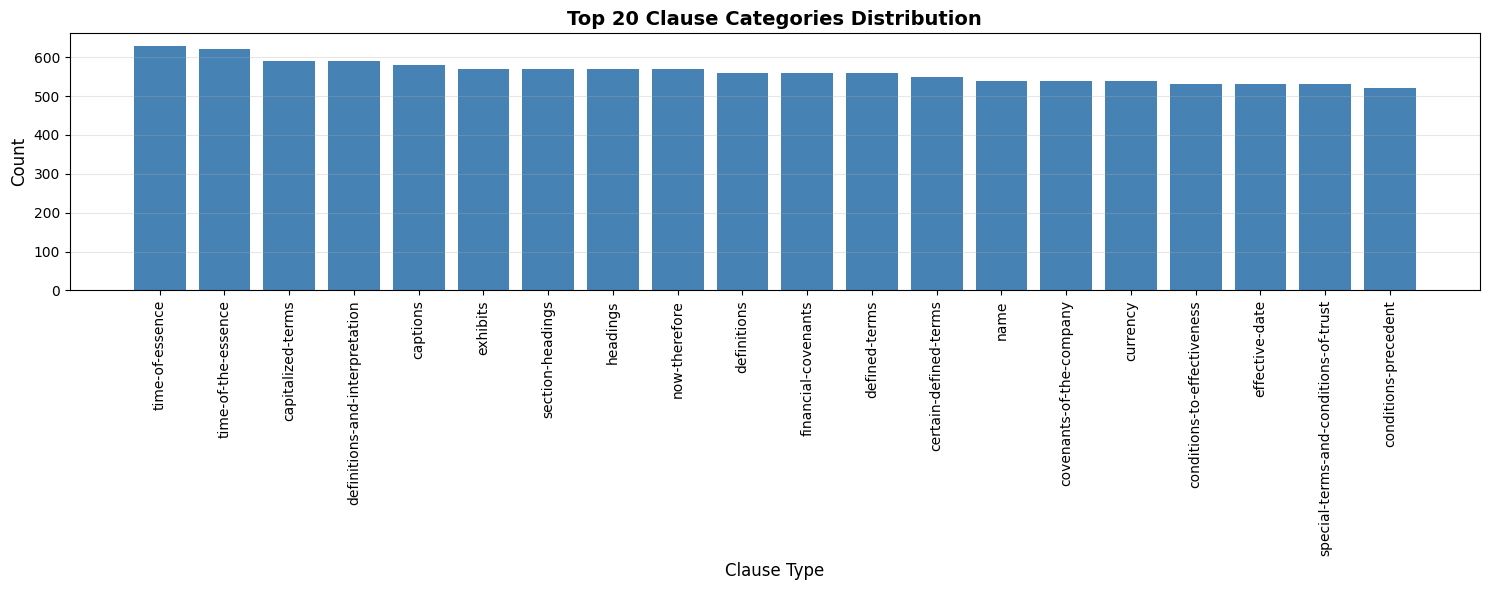

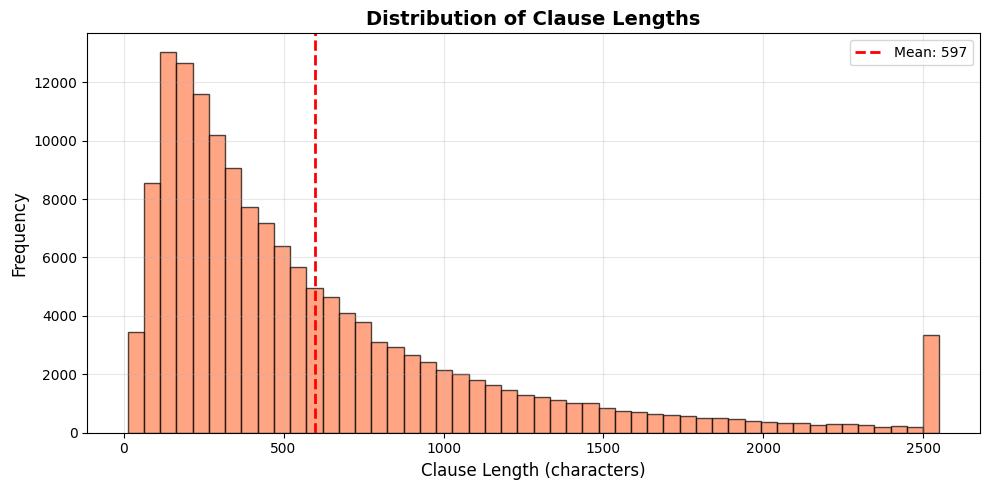

In [6]:
# Visualize category distribution (top 20 categories)
plt.figure(figsize=(15, 6))
top_categories = df['clause_type'].value_counts().head(20)
plt.bar(range(len(top_categories)), top_categories.values, color='steelblue')
plt.xticks(range(len(top_categories)), top_categories.index, rotation=90)
plt.xlabel('Clause Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 20 Clause Categories Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize clause length distribution
plt.figure(figsize=(10, 5))
clause_lengths = df['clause_text'].str.len()
plt.hist(clause_lengths, bins=50, edgecolor='black', color='coral', alpha=0.7)
plt.xlabel('Clause Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Clause Lengths', fontsize=14, fontweight='bold')
plt.axvline(clause_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {clause_lengths.mean():.0f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing and Pair Generation

In [7]:
class ClausePairGenerator:
    """Class to generate positive and negative clause pairs for similarity detection"""

    def __init__(self, df, num_pairs=50000):
        self.df = df
        self.num_pairs = num_pairs

    def generate_pairs(self):
        """Generate positive (similar) and negative (dissimilar) clause pairs"""
        pairs = []
        labels = []

        # Group by clause type
        grouped = self.df.groupby('clause_type')
        clause_types = list(grouped.groups.keys())

        print(f"Generating {self.num_pairs} clause pairs...")

        # Generate positive pairs (same category)
        num_positive = self.num_pairs // 2
        print(f"Generating {num_positive} positive (similar) pairs...")
        for i in range(num_positive):
            if i % 5000 == 0 and i > 0:
                print(f"  Generated {i} positive pairs...")

            # Select a random category
            category = random.choice(clause_types)
            category_clauses = grouped.get_group(category)['clause_text'].values

            if len(category_clauses) >= 2:
                # Sample two different clauses from same category
                clause1, clause2 = random.sample(list(category_clauses), 2)
                pairs.append((clause1, clause2))
                labels.append(1)  # Similar

        # Generate negative pairs (different categories)
        num_negative = self.num_pairs - len(pairs)
        print(f"Generating {num_negative} negative (dissimilar) pairs...")
        for i in range(num_negative):
            if i % 5000 == 0 and i > 0:
                print(f"  Generated {i} negative pairs...")

            # Select two different categories
            cat1, cat2 = random.sample(clause_types, 2)

            clause1 = random.choice(grouped.get_group(cat1)['clause_text'].values)
            clause2 = random.choice(grouped.get_group(cat2)['clause_text'].values)

            pairs.append((clause1, clause2))
            labels.append(0)  # Dissimilar

        print(f"\n✓ Pair generation complete!")
        return pairs, labels

# Generate clause pairs
pair_generator = ClausePairGenerator(df, num_pairs=50000)
pairs, labels = pair_generator.generate_pairs()

print(f"\n{'='*80}")
print(f"PAIR GENERATION SUMMARY")
print(f"{'='*80}")
print(f"Total pairs generated: {len(pairs)}")
print(f"Positive pairs (similar): {sum(labels)}")
print(f"Negative pairs (dissimilar): {len(labels) - sum(labels)}")
print(f"\nExample positive pair:")
print(f"Clause 1: {pairs[0][0][:200]}...")
print(f"Clause 2: {pairs[0][1][:200]}...")
print(f"Label: {labels[0]} (1 = Similar)")

Generating 50000 clause pairs...
Generating 25000 positive (similar) pairs...
  Generated 5000 positive pairs...
  Generated 10000 positive pairs...
  Generated 15000 positive pairs...
  Generated 20000 positive pairs...
Generating 25000 negative (dissimilar) pairs...
  Generated 5000 negative pairs...
  Generated 10000 negative pairs...
  Generated 15000 negative pairs...
  Generated 20000 negative pairs...

✓ Pair generation complete!

PAIR GENERATION SUMMARY
Total pairs generated: 50000
Positive pairs (similar): 25000
Negative pairs (dissimilar): 25000

Example positive pair:
Clause 1: Severability. It is the desire and intent of the parties hereto that the provisions of this Agreement be enforced to the fullest extent permissible under the laws and public policies applied in each j...
Clause 2: Severability. If one or more provisions of this Agreement are held to be unenforceable under applicable law, such provision shall be excluded from this Agreement and the balance of the Agree

In [8]:
class TextPreprocessor:
    """Class to handle text preprocessing and tokenization"""

    def __init__(self, max_words=20000, max_len=200):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = None

    def fit_tokenizer(self, texts):
        """Fit tokenizer on texts"""
        print(f"Fitting tokenizer on {len(texts)} texts...")
        self.tokenizer = Tokenizer(num_words=self.max_words, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(texts)
        print(f"✓ Vocabulary size: {len(self.tokenizer.word_index)}")
        print(f"✓ Using top {self.max_words} words")

    def preprocess_pairs(self, pairs):
        """Preprocess and tokenize clause pairs"""
        print(f"\nPreprocessing {len(pairs)} clause pairs...")
        clause1_texts = [pair[0] for pair in pairs]
        clause2_texts = [pair[1] for pair in pairs]

        # Convert to sequences
        print("Converting texts to sequences...")
        clause1_sequences = self.tokenizer.texts_to_sequences(clause1_texts)
        clause2_sequences = self.tokenizer.texts_to_sequences(clause2_texts)

        # Pad sequences
        print(f"Padding sequences to length {self.max_len}...")
        clause1_padded = pad_sequences(clause1_sequences, maxlen=self.max_len, padding='post', truncating='post')
        clause2_padded = pad_sequences(clause2_sequences, maxlen=self.max_len, padding='post', truncating='post')

        print("✓ Preprocessing complete!")
        return clause1_padded, clause2_padded

# Initialize preprocessor
preprocessor = TextPreprocessor(max_words=20000, max_len=200)

# Fit tokenizer on all clause texts
all_texts = [pair[0] for pair in pairs] + [pair[1] for pair in pairs]
preprocessor.fit_tokenizer(all_texts)

# Preprocess pairs
clause1_padded, clause2_padded = preprocessor.preprocess_pairs(pairs)
labels = np.array(labels)

print(f"\n{'='*80}")
print(f"PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"Clause 1 shape: {clause1_padded.shape}")
print(f"Clause 2 shape: {clause2_padded.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Memory usage: ~{(clause1_padded.nbytes + clause2_padded.nbytes) / 1024**2:.2f} MB")

Fitting tokenizer on 100000 texts...
✓ Vocabulary size: 37822
✓ Using top 20000 words

Preprocessing 50000 clause pairs...
Converting texts to sequences...
Padding sequences to length 200...
✓ Preprocessing complete!

PREPROCESSING SUMMARY
Clause 1 shape: (50000, 200)
Clause 2 shape: (50000, 200)
Labels shape: (50000,)
Memory usage: ~76.29 MB


## 6. Train-Test Split

In [9]:
# Split data into train, validation, and test sets
print("Splitting data into train, validation, and test sets...")

# First split: 80% train+val, 20% test
X1_temp, X1_test, X2_temp, X2_test, y_temp, y_test = train_test_split(
    clause1_padded, clause2_padded, labels,
    test_size=0.2, random_state=SEED, stratify=labels
)

# Second split: 75% train, 25% val (of the temp set)
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1_temp, X2_temp, y_temp,
    test_size=0.25, random_state=SEED, stratify=y_temp
)

print(f"\n{'='*80}")
print(f"DATA SPLIT SUMMARY")
print(f"{'='*80}")
print(f"Training set size: {len(X1_train):,} ({len(X1_train)/len(clause1_padded)*100:.1f}%)")
print(f"Validation set size: {len(X1_val):,} ({len(X1_val)/len(clause1_padded)*100:.1f}%)")
print(f"Test set size: {len(X1_test):,} ({len(X1_test)/len(clause1_padded)*100:.1f}%)")

print(f"\nClass Distribution:")
print(f"Train - Positive: {sum(y_train):,}, Negative: {len(y_train)-sum(y_train):,}")
print(f"Val   - Positive: {sum(y_val):,}, Negative: {len(y_val)-sum(y_val):,}")
print(f"Test  - Positive: {sum(y_test):,}, Negative: {len(y_test)-sum(y_test):,}")

Splitting data into train, validation, and test sets...

DATA SPLIT SUMMARY
Training set size: 30,000 (60.0%)
Validation set size: 10,000 (20.0%)
Test set size: 10,000 (20.0%)

Class Distribution:
Train - Positive: 15,000, Negative: 15,000
Val   - Positive: 5,000, Negative: 5,000
Test  - Positive: 5,000, Negative: 5,000


## 7. Model Architecture 1: Siamese BiLSTM Network

In [11]:

class SiameseBiLSTM:
    """Siamese Network with Bidirectional LSTM for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, lstm_units=128, max_len=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_len = max_len
        self.model = None

    def build_encoder(self):
        """Build the shared encoder for both clauses"""
        inputs = Input(shape=(self.max_len,))

        # Embedding layer
        embedding = Embedding(input_dim=self.vocab_size,
                            output_dim=self.embedding_dim,
                            mask_zero=True)(inputs)

        # Bidirectional LSTM
        lstm_out = Bidirectional(LSTM(self.lstm_units, return_sequences=True))(embedding)
        lstm_out = Dropout(0.3)(lstm_out)

        # Second Bidirectional LSTM
        lstm_out = Bidirectional(LSTM(self.lstm_units // 2, return_sequences=False))(lstm_out)
        lstm_out = Dropout(0.3)(lstm_out)

        # Dense layer for final encoding
        encoded = Dense(128, activation='relu')(lstm_out)
        encoded = Dropout(0.2)(encoded)

        encoder = Model(inputs=inputs, outputs=encoded, name='BiLSTM_Encoder')
        return encoder

    def build_model(self):
        """Build the complete Siamese network"""
        from tensorflow.keras.layers import Lambda, Subtract, Multiply

        # Build shared encoder
        encoder = self.build_encoder()

        # Define inputs for both clauses
        input_clause1 = Input(shape=(self.max_len,), name='clause1')
        input_clause2 = Input(shape=(self.max_len,), name='clause2')

        # Encode both clauses using shared encoder
        encoded_clause1 = encoder(input_clause1)
        encoded_clause2 = encoder(input_clause2)

        # Calculate similarity using multiple methods
        # 1. Concatenate encodings
        concatenated = Concatenate()([encoded_clause1, encoded_clause2])

        # 2. Element-wise absolute difference (using Lambda layer for TF operations)
        diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_clause1, encoded_clause2])

        # 3. Element-wise product (using Multiply layer)
        product = Multiply()([encoded_clause1, encoded_clause2])

        # Combine all similarity features
        combined = Concatenate()([concatenated, diff, product])

        # Classification layers
        dense1 = Dense(128, activation='relu')(combined)
        dense1 = Dropout(0.3)(dense1)

        dense2 = Dense(64, activation='relu')(dense1)
        dense2 = Dropout(0.2)(dense2)

        # Output layer (binary classification)
        output = Dense(1, activation='sigmoid', name='similarity_score')(dense2)

        # Create model
        self.model = Model(inputs=[input_clause1, input_clause2], outputs=output, name='Siamese_BiLSTM')

        return self.model


# Similarly, fix the SiameseAttentionEncoder class

class SiameseAttentionEncoder:
    """Siamese Network with Multi-Head Attention for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, num_heads=4, max_len=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.max_len = max_len
        self.model = None

    def build_encoder(self):
        """Build the shared attention-based encoder"""
        inputs = Input(shape=(self.max_len,))

        # Embedding layer
        embedding = Embedding(input_dim=self.vocab_size,
                            output_dim=self.embedding_dim,
                            mask_zero=True)(inputs)

        # Multi-Head Attention layer
        attention_output = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embedding_dim // self.num_heads
        )(embedding, embedding)

        # Add & Norm
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding)
        attention_output = Dropout(0.2)(attention_output)

        # Feed Forward Network
        ffn = Dense(256, activation='relu')(attention_output)
        ffn = Dropout(0.2)(ffn)
        ffn = Dense(self.embedding_dim)(ffn)

        # Add & Norm
        ffn_output = LayerNormalization(epsilon=1e-6)(ffn + attention_output)

        # Global Max Pooling to get fixed-size representation
        pooled = GlobalMaxPooling1D()(ffn_output)

        # Dense layer for final encoding
        encoded = Dense(128, activation='relu')(pooled)
        encoded = Dropout(0.2)(encoded)

        encoder = Model(inputs=inputs, outputs=encoded, name='Attention_Encoder')
        return encoder

    def build_model(self):
        """Build the complete Siamese attention network"""
        from tensorflow.keras.layers import Lambda, Multiply

        # Build shared encoder
        encoder = self.build_encoder()

        # Define inputs for both clauses
        input_clause1 = Input(shape=(self.max_len,), name='clause1')
        input_clause2 = Input(shape=(self.max_len,), name='clause2')

        # Encode both clauses using shared encoder
        encoded_clause1 = encoder(input_clause1)
        encoded_clause2 = encoder(input_clause2)

        # Calculate similarity features
        # 1. Concatenate encodings
        concatenated = Concatenate()([encoded_clause1, encoded_clause2])

        # 2. Element-wise absolute difference (using Lambda)
        diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_clause1, encoded_clause2])

        # 3. Element-wise product (using Multiply)
        product = Multiply()([encoded_clause1, encoded_clause2])

        # 4. Cosine similarity (using Lambda)
        def cosine_similarity(tensors):
            x, y = tensors
            dot_product = tf.reduce_sum(x * y, axis=1, keepdims=True)
            norm1 = tf.sqrt(tf.reduce_sum(tf.square(x), axis=1, keepdims=True))
            norm2 = tf.sqrt(tf.reduce_sum(tf.square(y), axis=1, keepdims=True))
            return dot_product / (norm1 * norm2 + 1e-8)

        cosine_sim = Lambda(cosine_similarity)([encoded_clause1, encoded_clause2])

        # Combine all similarity features
        combined = Concatenate()([concatenated, diff, product, cosine_sim])

        # Classification layers
        dense1 = Dense(128, activation='relu')(combined)
        dense1 = Dropout(0.3)(dense1)

        dense2 = Dense(64, activation='relu')(dense1)
        dense2 = Dropout(0.2)(dense2)

        # Output layer
        output = Dense(1, activation='sigmoid', name='similarity_score')(dense2)

        # Create model
        self.model = Model(inputs=[input_clause1, input_clause2], outputs=output, name='Siamese_Attention')

        return self.model


# Build Siamese BiLSTM model
print("Building Siamese BiLSTM model...")
bilstm_model = SiameseBiLSTM(
    vocab_size=preprocessor.max_words,
    embedding_dim=128,
    lstm_units=128,
    max_len=preprocessor.max_len
)

model_bilstm = bilstm_model.build_model()
print("\n" + "="*80)
print("SIAMESE BiLSTM MODEL ARCHITECTURE")
print("="*80)
model_bilstm.summary()
print("\n✓ Model built successfully!")

Building Siamese BiLSTM model...

SIAMESE BiLSTM MODEL ARCHITECTURE


Model: "Siamese_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause1             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause2             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Encoder      │ (None, 128)       │  3,004,032 │ clause1[0][0],    │
│ (Functional)        │                   │            │ clause2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ BiLSTM_Encoder[0… │
│ (Concatenate)       │                   │            │ BiLSTM_Encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ BiLSTM_Encoder[0… │
│                     │                   │            │ BiLSTM_Encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ BiLSTM_Encoder[0… │
│                     │                   │            │ BiLSTM_Encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ concatenate_1[0]… │
│ (Concatenate)       │                   │            │ lambda[0][0],     │
│                     │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_score    │ (None, 1)         │         65 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,078,017 (11.74 MB)

 Trainable params: 3,078,017 (11.74 MB)

 Non-trainable params: 0 (0.00 B)


✓ Model built successfully!


## 8. Model Architecture 2: Siamese Attention-Based Encoder

In [13]:
class SiameseAttentionEncoder:
    """Siamese Network with Multi-Head Attention for clause similarity"""

    def __init__(self, vocab_size, embedding_dim=128, num_heads=4, max_len=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.max_len = max_len
        self.model = None

    def build_encoder(self):
        """Build the shared attention-based encoder"""
        inputs = Input(shape=(self.max_len,))

        # Embedding layer
        embedding = Embedding(input_dim=self.vocab_size,
                            output_dim=self.embedding_dim,
                            mask_zero=True)(inputs)

        # Multi-Head Attention layer
        attention_output = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embedding_dim // self.num_heads
        )(embedding, embedding)

        # Add & Norm
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding)
        attention_output = Dropout(0.2)(attention_output)

        # Feed Forward Network
        ffn = Dense(256, activation='relu')(attention_output)
        ffn = Dropout(0.2)(ffn)
        ffn = Dense(self.embedding_dim)(ffn)

        # Add & Norm
        ffn_output = LayerNormalization(epsilon=1e-6)(ffn + attention_output)

        # Global Max Pooling to get fixed-size representation
        pooled = GlobalMaxPooling1D()(ffn_output)

        # Dense layer for final encoding
        encoded = Dense(128, activation='relu')(pooled)
        encoded = Dropout(0.2)(encoded)

        encoder = Model(inputs=inputs, outputs=encoded, name='Attention_Encoder')
        return encoder

    def build_model(self):
        """Build the complete Siamese attention network"""
        from tensorflow.keras.layers import Lambda, Multiply

        # Build shared encoder
        encoder = self.build_encoder()

        # Define inputs for both clauses
        input_clause1 = Input(shape=(self.max_len,), name='clause1')
        input_clause2 = Input(shape=(self.max_len,), name='clause2')

        # Encode both clauses using shared encoder
        encoded_clause1 = encoder(input_clause1)
        encoded_clause2 = encoder(input_clause2)

        # Calculate similarity features
        # 1. Concatenate encodings
        concatenated = Concatenate()([encoded_clause1, encoded_clause2])

        # 2. Element-wise absolute difference (FIXED - using Lambda)
        diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_clause1, encoded_clause2])

        # 3. Element-wise product (FIXED - using Multiply)
        product = Multiply()([encoded_clause1, encoded_clause2])

        # 4. Cosine similarity (FIXED - wrapped in Lambda)
        def cosine_similarity(tensors):
            x, y = tensors
            dot_product = tf.reduce_sum(x * y, axis=1, keepdims=True)
            norm1 = tf.sqrt(tf.reduce_sum(tf.square(x), axis=1, keepdims=True))
            norm2 = tf.sqrt(tf.reduce_sum(tf.square(y), axis=1, keepdims=True))
            return dot_product / (norm1 * norm2 + 1e-8)

        cosine_sim = Lambda(cosine_similarity)([encoded_clause1, encoded_clause2])

        # Combine all similarity features
        combined = Concatenate()([concatenated, diff, product, cosine_sim])

        # Classification layers
        dense1 = Dense(128, activation='relu')(combined)
        dense1 = Dropout(0.3)(dense1)

        dense2 = Dense(64, activation='relu')(dense1)
        dense2 = Dropout(0.2)(dense2)

        # Output layer
        output = Dense(1, activation='sigmoid', name='similarity_score')(dense2)

        # Create model
        self.model = Model(inputs=[input_clause1, input_clause2], outputs=output, name='Siamese_Attention')

        return self.model

# Build Siamese Attention model
print("Building Siamese Attention model...")
attention_model = SiameseAttentionEncoder(
    vocab_size=preprocessor.max_words,
    embedding_dim=128,
    num_heads=4,
    max_len=preprocessor.max_len
)

model_attention = attention_model.build_model()
print("\n" + "="*80)
print("SIAMESE ATTENTION MODEL ARCHITECTURE")
print("="*80)
model_attention.summary()
print("\n✓ Model built successfully!")

Building Siamese Attention model...

SIAMESE ATTENTION MODEL ARCHITECTURE


Model: "Siamese_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause1             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause2             │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention_Encoder   │ (None, 128)       │  2,708,992 │ clause1[0][0],    │
│ (Functional)        │                   │            │ clause2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256)       │          0 │ Attention_Encode… │
│ (Concatenate)       │                   │            │ Attention_Encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ Attention_Encode… │
│                     │                   │            │ Attention_Encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128)       │          0 │ Attention_Encode… │
│ (Multiply)          │                   │            │ Attention_Encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ Attention_Encode… │
│                     │                   │            │ Attention_Encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 513)       │          0 │ concatenate_4[0]… │
│ (Concatenate)       │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ multiply_1[0][0], │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     65,792 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_score    │ (None, 1)         │         65 │ dropout_17[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,783,105 (10.62 MB)

 Trainable params: 2,783,105 (10.62 MB)

 Non-trainable params: 0 (0.00 B)


✓ Model built successfully!


## 9. Model Training Configuration

In [14]:
import time

class ModelTrainer:
    """Class to handle model training and evaluation"""

    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer and loss"""
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        print(f"✓ {self.model_name} compiled successfully!")

    def get_callbacks(self):
        """Define training callbacks"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1
            )
        ]
        return callbacks

    def train(self, X1_train, X2_train, y_train, X1_val, X2_val, y_val,
              epochs=30, batch_size=64):
        """Train the model"""
        callbacks = self.get_callbacks()

        print(f"\n{'='*80}")
        print(f"TRAINING {self.model_name}")
        print(f"{'='*80}")
        print(f"Epochs: {epochs}")
        print(f"Batch Size: {batch_size}")
        print(f"Training samples: {len(X1_train):,}")
        print(f"Validation samples: {len(X1_val):,}")
        print(f"{'='*80}\n")

        self.history = self.model.fit(
            [X1_train, X2_train], y_train,
            validation_data=([X1_val, X2_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available!")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[0, 0].set_title(f'{self.model_name} - Accuracy', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot loss
        axes[0, 1].plot(self.history.history['loss'], label='Train Loss', linewidth=2)
        axes[0, 1].plot(self.history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[0, 1].set_title(f'{self.model_name} - Loss', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot precision
        axes[1, 0].plot(self.history.history['precision'], label='Train Precision', linewidth=2)
        axes[1, 0].plot(self.history.history['val_precision'], label='Val Precision', linewidth=2)
        axes[1, 0].set_title(f'{self.model_name} - Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot AUC
        axes[1, 1].plot(self.history.history['auc'], label='Train AUC', linewidth=2)
        axes[1, 1].plot(self.history.history['val_auc'], label='Val AUC', linewidth=2)
        axes[1, 1].set_title(f'{self.model_name} - AUC', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('AUC')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.model_name}_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Training history plot saved as '{self.model_name}_training_history.png'")

print("✓ ModelTrainer class defined successfully!")

✓ ModelTrainer class defined successfully!


## 10. Train BiLSTM Model

✓ Siamese_BiLSTM compiled successfully!

TRAINING Siamese_BiLSTM
Epochs: 30
Batch Size: 64
Training samples: 30,000
Validation samples: 10,000

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.5701 - auc: 0.6104 - loss: 0.6341 - precision: 0.5709 - recall: 0.5163 - val_accuracy: 0.8898 - val_auc: 0.9550 - val_loss: 0.2734 - val_precision: 0.8196 - val_recall: 0.9996 - learning_rate: 0.0010
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.9139 - auc: 0.9461 - loss: 0.2429 - precision: 0.8688 - recall: 0.9746 - val_accuracy: 0.9197 - val_auc: 0.9772 - val_loss: 0.2279 - val_precision: 0.8624 - val_recall: 0.9988 - learning_rate: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.9378 - auc: 0.9688 - loss: 0.1827 - precision: 0.9060 - recall: 0.9766 - val_accuracy: 0.9338 - val_auc: 0.9764 - val_loss: 0.2230 - val_precision: 0.8844 - val_recall: 0.9980 - learning_rate: 0.0010
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/ste

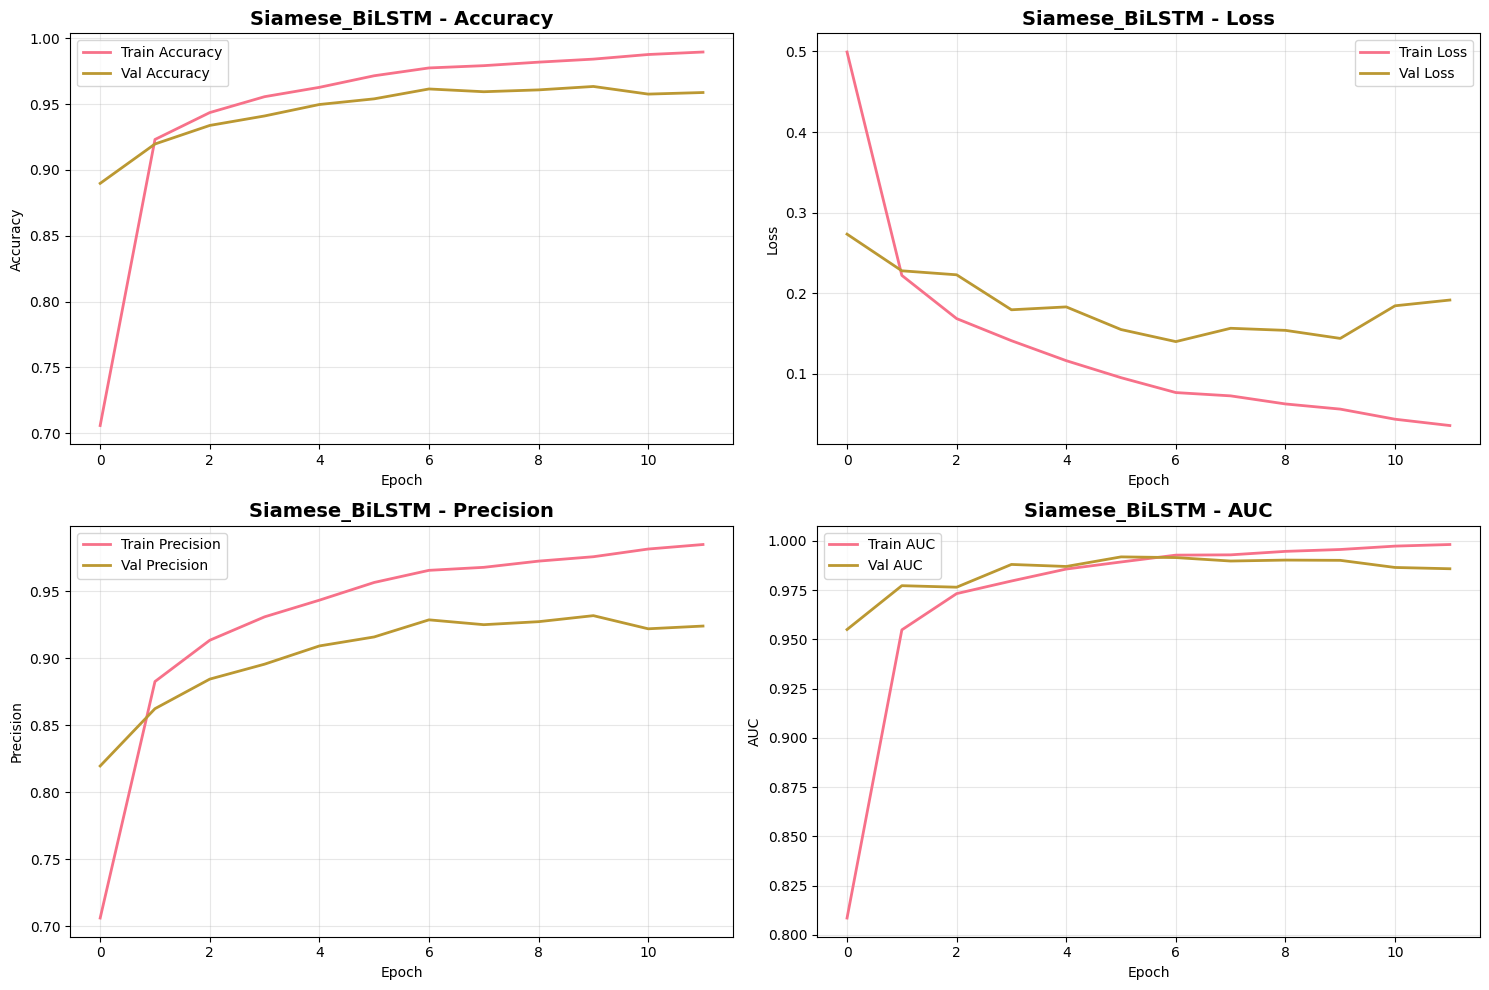

✓ Training history plot saved as 'Siamese_BiLSTM_training_history.png'


In [15]:
# Initialize trainer for BiLSTM
bilstm_trainer = ModelTrainer(model_bilstm, "Siamese_BiLSTM")
bilstm_trainer.compile_model(learning_rate=0.001)

# Train the model
start_time = time.time()
history_bilstm = bilstm_trainer.train(
    X1_train, X2_train, y_train,
    X1_val, X2_val, y_val,
    epochs=30,
    batch_size=64
)
bilstm_training_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"✓ BiLSTM Training completed in {bilstm_training_time:.2f} seconds ({bilstm_training_time/60:.2f} minutes)")
print(f"{'='*80}")

# Plot training history
bilstm_trainer.plot_training_history()

## 11. Train Attention Model

✓ Siamese_Attention compiled successfully!

TRAINING Siamese_Attention
Epochs: 30
Batch Size: 64
Training samples: 30,000
Validation samples: 10,000

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.5069 - auc_1: 0.5050 - loss: 0.7505 - precision_1: 0.5052 - recall_1: 0.5102 - val_accuracy: 0.5000 - val_auc_1: 0.5038 - val_loss: 0.6934 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5044 - auc_1: 0.5062 - loss: 0.6934 - precision_1: 0.5042 - recall_1: 0.4269 - val_accuracy: 0.5169 - val_auc_1: 0.5370 - val_loss: 0.6927 - val_precision_1: 0.5134 - val_recall_1: 0.6472 - learning_rate: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5177 - auc_1: 0.5266 - loss: 0.6911 - precision_1: 0.5225 - recall_1: 0.3455 - val_accuracy: 0.6398 - val_auc_1: 0.6913 - val_loss: 0.6362 - val_precision_1: 0.6106 - val_recall_1: 0.7716 - learning_rate: 0.0010
Ep

KeyError: 'precision'

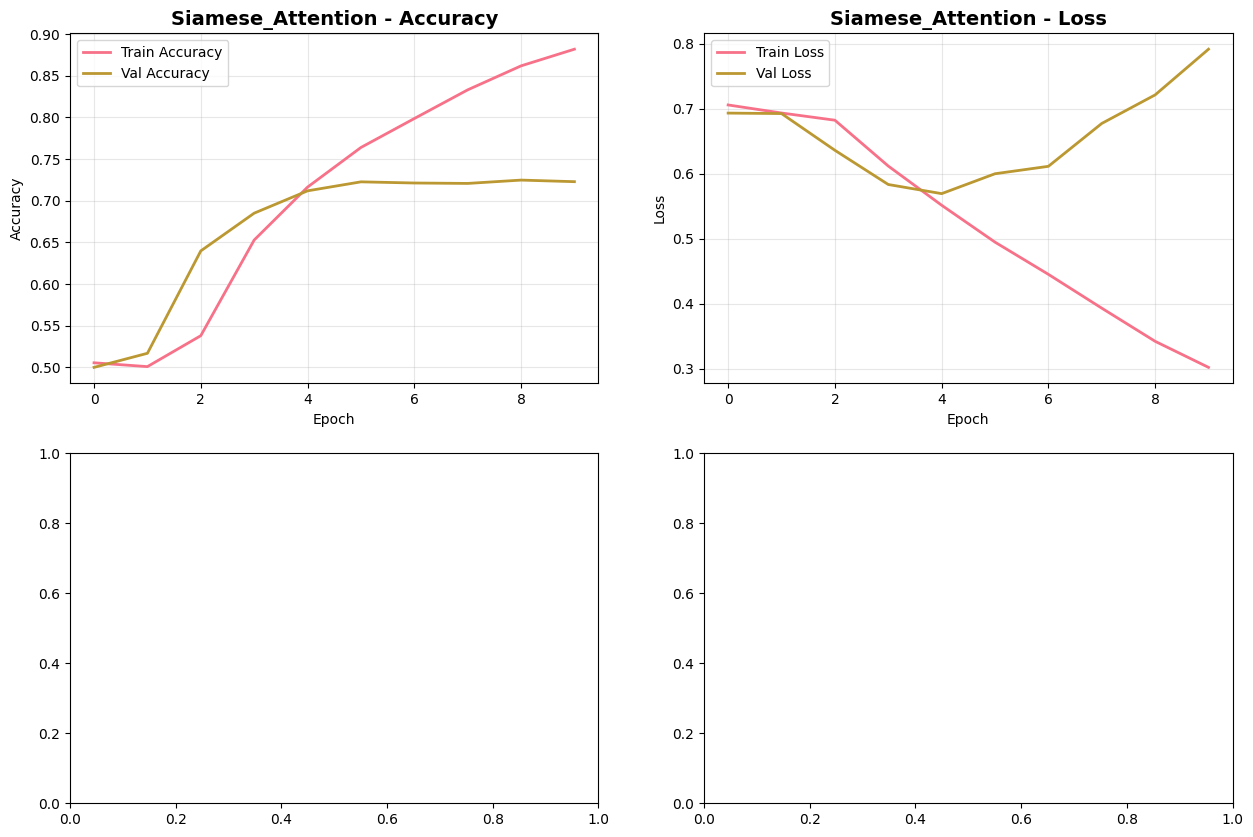

In [16]:
# Initialize trainer for Attention model
attention_trainer = ModelTrainer(model_attention, "Siamese_Attention")
attention_trainer.compile_model(learning_rate=0.001)

# Train the model
start_time = time.time()
history_attention = attention_trainer.train(
    X1_train, X2_train, y_train,
    X1_val, X2_val, y_val,
    epochs=30,
    batch_size=64
)
attention_training_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"✓ Attention Model Training completed in {attention_training_time:.2f} seconds ({attention_training_time/60:.2f} minutes)")
print(f"{'='*80}")

# Plot training history
attention_trainer.plot_training_history()

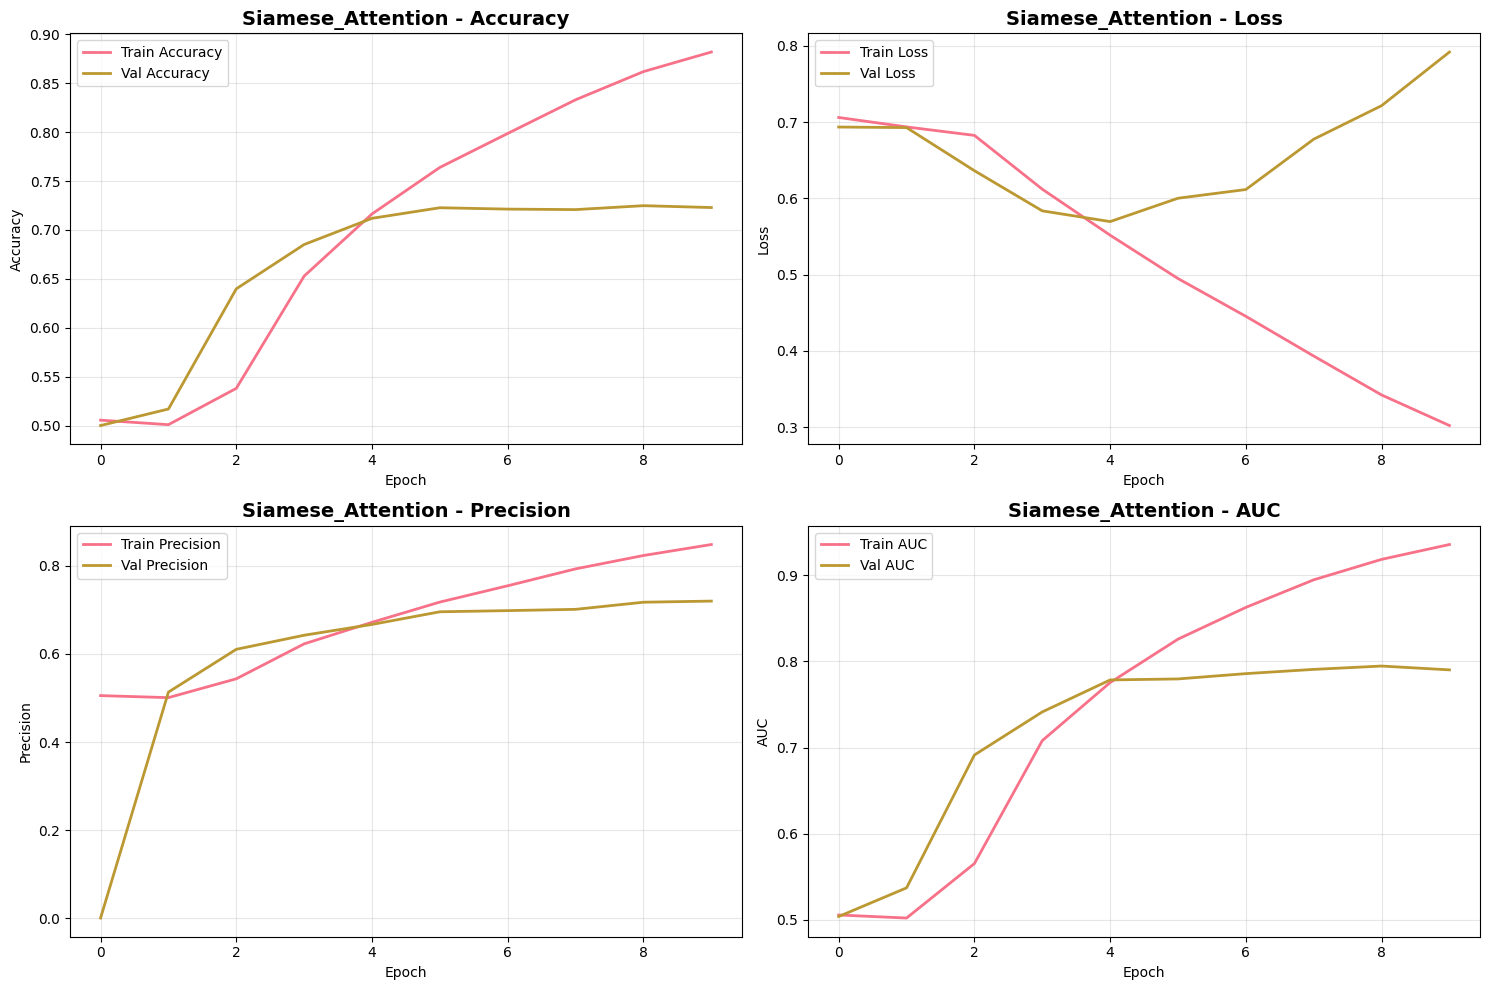

✓ Training history plot saved!


In [18]:
# Manual plot for Attention model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot accuracy
axes[0, 0].plot(history_attention.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history_attention.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Siamese_Attention - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot loss
axes[0, 1].plot(history_attention.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history_attention.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Siamese_Attention - Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot precision
axes[1, 0].plot(history_attention.history['precision_1'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history_attention.history['val_precision_1'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Siamese_Attention - Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot AUC
axes[1, 1].plot(history_attention.history['auc_1'], label='Train AUC', linewidth=2)
axes[1, 1].plot(history_attention.history['val_auc_1'], label='Val AUC', linewidth=2)
axes[1, 1].set_title('Siamese_Attention - AUC', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Siamese_Attention_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Training history plot saved!")

## 12. Model Evaluation

In [19]:
class ModelEvaluator:
    """Class to evaluate model performance"""

    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name

    def evaluate(self, X1_test, X2_test, y_test):
        """Evaluate model on test set"""
        print(f"\nEvaluating {self.model_name} on test set...")

        # Get predictions
        y_pred_proba = self.model.predict([X1_test, X2_test], verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except:
            roc_auc = 0.0

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }

        return metrics, y_pred, y_pred_proba

    def print_metrics(self, metrics):
        """Print evaluation metrics"""
        print(f"\n{'='*80}")
        print(f"{self.model_name} - TEST SET METRICS")
        print(f"{'='*80}")
        print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
        print(f"Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
        print(f"Recall:    {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
        print(f"F1-Score:  {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)")
        print(f"ROC-AUC:   {metrics['roc_auc']:.4f} ({metrics['roc_auc']*100:.2f}%)")
        print(f"{'='*80}\n")

    def plot_confusion_matrix(self, y_test, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Dissimilar', 'Similar'],
                   yticklabels=['Dissimilar', 'Similar'],
                   cbar_kws={'label': 'Count'})
        plt.title(f'{self.model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{self.model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Confusion matrix saved as '{self.model_name}_confusion_matrix.png'")

    def plot_roc_curve(self, y_test, y_pred_proba):
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'{self.model_name} - ROC Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.model_name}_roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ ROC curve saved as '{self.model_name}_roc_curve.png'")

    def plot_precision_recall_curve(self, y_test, y_pred_proba):
        """Plot Precision-Recall curve"""
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_vals, precision_vals)

        plt.figure(figsize=(8, 6))
        plt.plot(recall_vals, precision_vals, color='blue', lw=2,
                label=f'PR curve (AUC = {pr_auc:.4f})')
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'{self.model_name} - Precision-Recall Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.model_name}_pr_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ PR curve saved as '{self.model_name}_pr_curve.png'")

print("✓ ModelEvaluator class defined successfully!")

✓ ModelEvaluator class defined successfully!



Evaluating Siamese_BiLSTM on test set...

Siamese_BiLSTM - TEST SET METRICS
Accuracy:  0.9584 (95.84%)
Precision: 0.9237 (92.37%)
Recall:    0.9994 (99.94%)
F1-Score:  0.9600 (96.00%)
ROC-AUC:   0.9934 (99.34%)



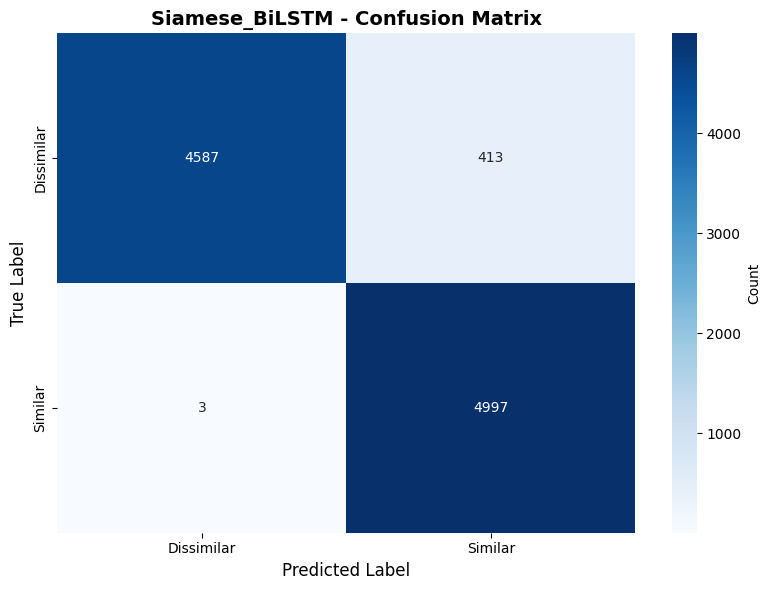

✓ Confusion matrix saved as 'Siamese_BiLSTM_confusion_matrix.png'


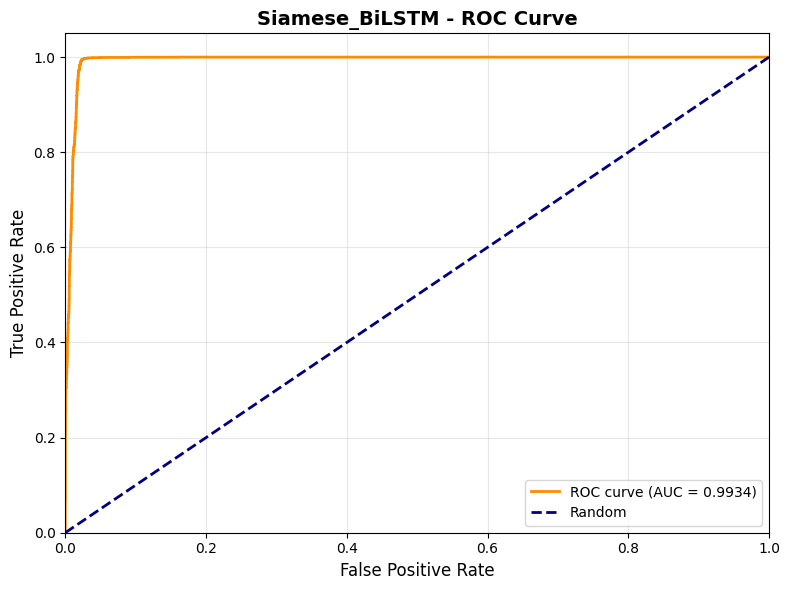

✓ ROC curve saved as 'Siamese_BiLSTM_roc_curve.png'


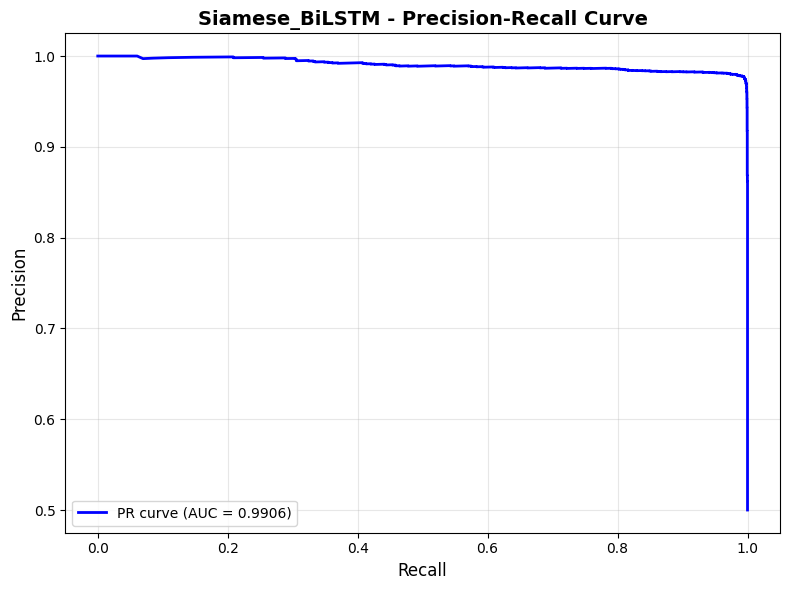

✓ PR curve saved as 'Siamese_BiLSTM_pr_curve.png'


In [20]:
# Evaluate BiLSTM Model
bilstm_evaluator = ModelEvaluator(model_bilstm, "Siamese_BiLSTM")
bilstm_metrics, bilstm_pred, bilstm_pred_proba = bilstm_evaluator.evaluate(X1_test, X2_test, y_test)
bilstm_evaluator.print_metrics(bilstm_metrics)

# Plot visualizations
bilstm_evaluator.plot_confusion_matrix(y_test, bilstm_pred)
bilstm_evaluator.plot_roc_curve(y_test, bilstm_pred_proba)
bilstm_evaluator.plot_precision_recall_curve(y_test, bilstm_pred_proba)


Evaluating Siamese_Attention on test set...

Siamese_Attention - TEST SET METRICS
Accuracy:  0.7015 (70.15%)
Precision: 0.6578 (65.78%)
Recall:    0.8398 (83.98%)
F1-Score:  0.7378 (73.78%)
ROC-AUC:   0.7714 (77.14%)



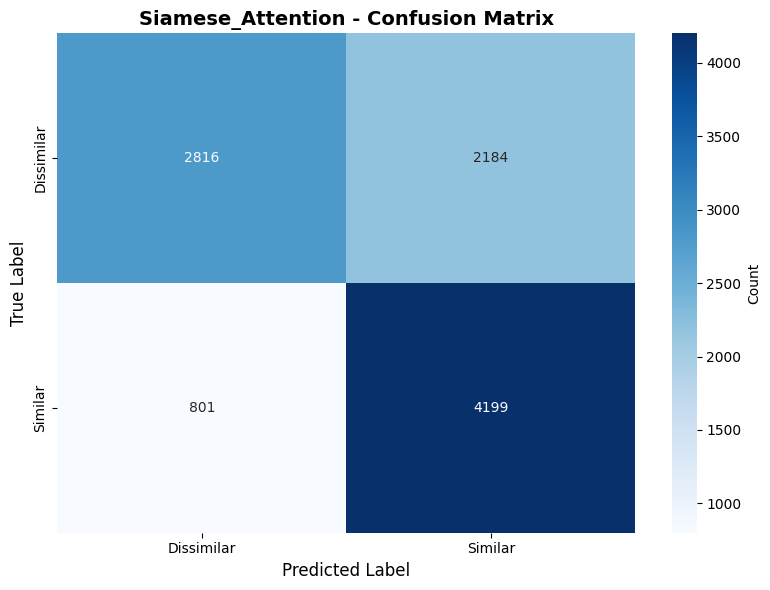

✓ Confusion matrix saved as 'Siamese_Attention_confusion_matrix.png'


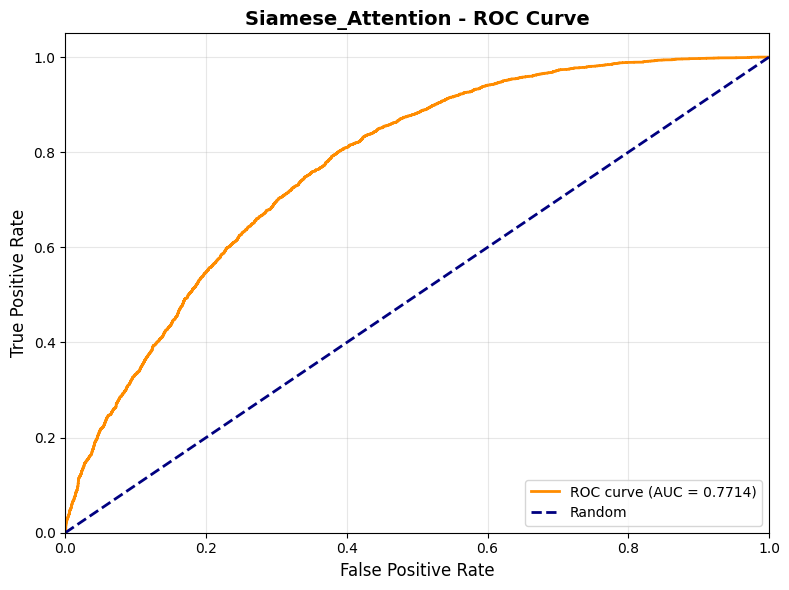

✓ ROC curve saved as 'Siamese_Attention_roc_curve.png'


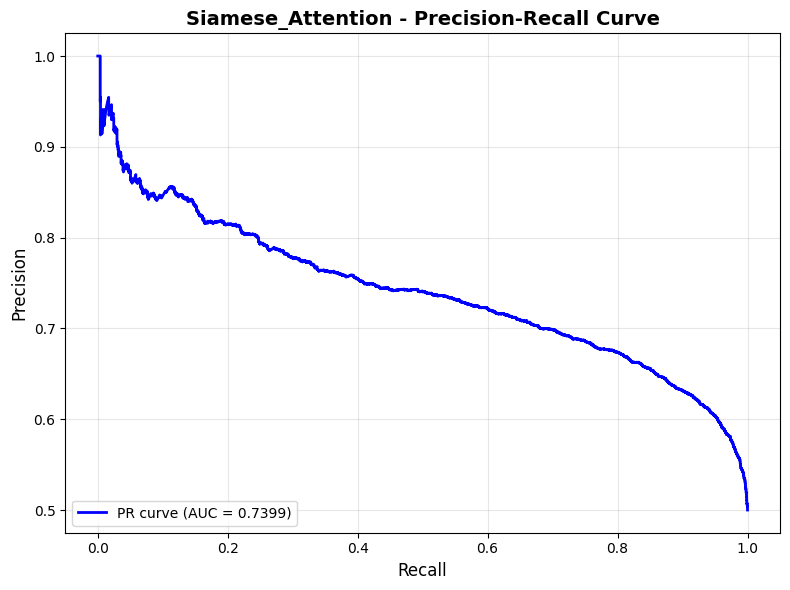

✓ PR curve saved as 'Siamese_Attention_pr_curve.png'


In [21]:
# Evaluate Attention Model
attention_evaluator = ModelEvaluator(model_attention, "Siamese_Attention")
attention_metrics, attention_pred, attention_pred_proba = attention_evaluator.evaluate(X1_test, X2_test, y_test)
attention_evaluator.print_metrics(attention_metrics)

# Plot visualizations
attention_evaluator.plot_confusion_matrix(y_test, attention_pred)
attention_evaluator.plot_roc_curve(y_test, attention_pred_proba)
attention_evaluator.plot_precision_recall_curve(y_test, attention_pred_proba)

## 13. Model Comparison


MODEL COMPARISON - FINAL RESULTS
            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Training Time (s)
   Siamese BiLSTM    0.9584   0.923660  0.9994  0.960038 0.993388         485.586154
Siamese Attention    0.7015   0.657841  0.8398  0.737767 0.771437         151.889021

✓ Comparison results saved as 'model_comparison_results.csv'


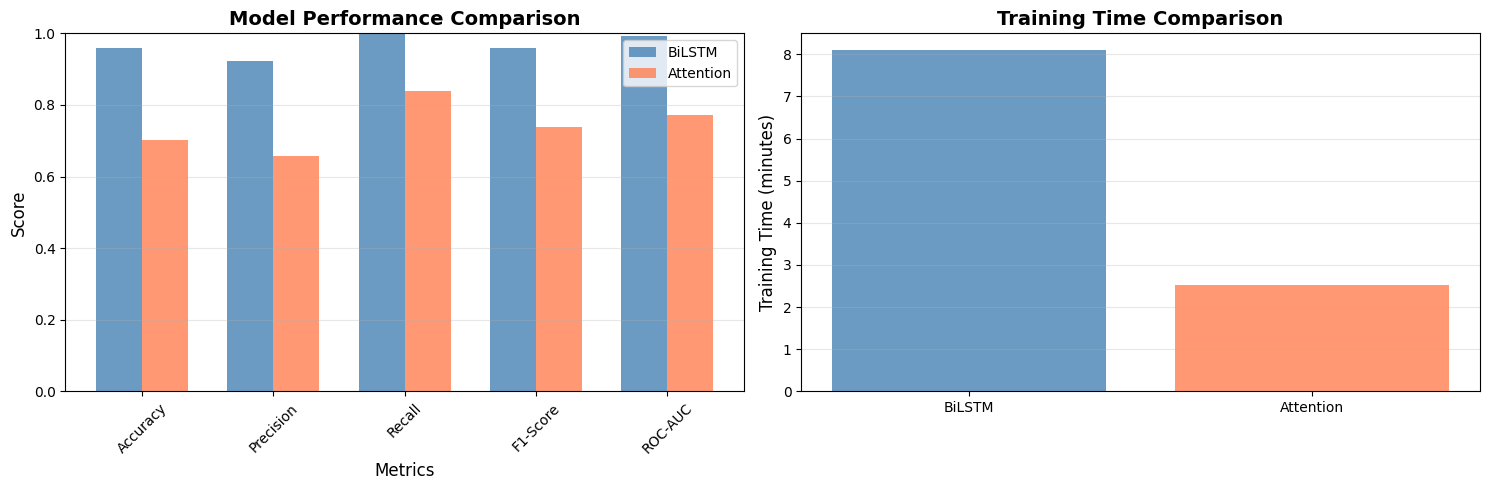

✓ Comparison plot saved as 'model_comparison.png'


In [22]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Siamese BiLSTM', 'Siamese Attention'],
    'Accuracy': [bilstm_metrics['accuracy'], attention_metrics['accuracy']],
    'Precision': [bilstm_metrics['precision'], attention_metrics['precision']],
    'Recall': [bilstm_metrics['recall'], attention_metrics['recall']],
    'F1-Score': [bilstm_metrics['f1_score'], attention_metrics['f1_score']],
    'ROC-AUC': [bilstm_metrics['roc_auc'], attention_metrics['roc_auc']],
    'Training Time (s)': [bilstm_training_time, attention_training_time]
})

print("\n" + "="*100)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100 + "\n")

# Save comparison
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("✓ Comparison results saved as 'model_comparison_results.csv'")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

axes[0].bar(x - width/2, comparison_df.iloc[0, 1:6], width, label='BiLSTM', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, comparison_df.iloc[1, 1:6], width, label='Attention', alpha=0.8, color='coral')
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_to_plot, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Plot training time comparison
axes[1].bar(['BiLSTM', 'Attention'], comparison_df['Training Time (s)']/60, alpha=0.8, color=['steelblue', 'coral'])
axes[1].set_ylabel('Training Time (minutes)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Comparison plot saved as 'model_comparison.png'")

## 14. Qualitative Results - Examples

In [23]:
def show_prediction_examples(pairs, labels, predictions, proba, num_examples=3, correct=True):
    """Show examples of correct or incorrect predictions"""

    # Find indices
    if correct:
        indices = np.where(predictions.flatten() == labels)[0]
        print(f"\n{'='*100}")
        print(f"CORRECTLY PREDICTED EXAMPLES")
        print(f"{'='*100}\n")
    else:
        indices = np.where(predictions.flatten() != labels)[0]
        print(f"\n{'='*100}")
        print(f"INCORRECTLY PREDICTED EXAMPLES")
        print(f"{'='*100}\n")

    # Sample random indices
    if len(indices) > num_examples:
        sample_indices = np.random.choice(indices, num_examples, replace=False)
    else:
        sample_indices = indices[:num_examples]

    # Get original pairs for display
    test_pairs = pairs[-len(labels):]

    for i, idx in enumerate(sample_indices):
        print(f"Example {i+1}:")
        print(f"-" * 100)

        pair = test_pairs[idx]

        print(f"Clause 1: {pair[0][:300]}...")
        print(f"\nClause 2: {pair[1][:300]}...")
        print(f"\nTrue Label: {'Similar' if labels[idx] == 1 else 'Dissimilar'}")
        print(f"Predicted Label: {'Similar' if predictions[idx][0] == 1 else 'Dissimilar'}")
        print(f"Confidence: {proba[idx][0]:.4f}")
        print(f"\n{'='*100}\n")

# Show examples for BiLSTM
print("\n" + "#"*100)
print("SIAMESE BiLSTM MODEL - PREDICTION EXAMPLES")
print("#"*100)

show_prediction_examples(pairs, y_test, bilstm_pred, bilstm_pred_proba, num_examples=3, correct=True)
show_prediction_examples(pairs, y_test, bilstm_pred, bilstm_pred_proba, num_examples=3, correct=False)

# Show examples for Attention
print("\n" + "#"*100)
print("SIAMESE ATTENTION MODEL - PREDICTION EXAMPLES")
print("#"*100)

show_prediction_examples(pairs, y_test, attention_pred, attention_pred_proba, num_examples=3, correct=True)
show_prediction_examples(pairs, y_test, attention_pred, attention_pred_proba, num_examples=3, correct=False)


####################################################################################################
SIAMESE BiLSTM MODEL - PREDICTION EXAMPLES
####################################################################################################

CORRECTLY PREDICTED EXAMPLES

Example 1:
----------------------------------------------------------------------------------------------------
Clause 1: Exclusions. Section 7.1(a) shall not apply to (i) sales of shares of Common Stock by the Company upon conversion or exercise of any convertible securities, options or warrants outstanding prior to the date hereof; or (ii) sales of shares of Common Stock by the Company pursuant to the provisions of a...

Clause 2: Access. The Parent has cooperated fully in permitting the Shareholders and their representatives to make a full investigation of the properties, operations and financial condition of the Parent and has afforded the Shareholders and their representatives reasonable access to the offices

## 15. Save Models and Results

In [25]:
# Save models
print("Saving models...")
model_bilstm.save('siamese_bilstm_final.h5')
model_attention.save('siamese_attention_final.h5')

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(preprocessor.tokenizer, f)

print("\n" + "="*80)
print("ALL FILES SAVED SUCCESSFULLY!")
print("="*80)
print("\nFiles saved:")
print("  1. siamese_bilstm_final.h5")
print("  2. siamese_attention_final.h5")
print("  3. tokenizer.pkl")
print("  4. model_comparison_results.csv")
print("  5. Siamese_BiLSTM_training_history.png")
print("  6. Siamese_Attention_training_history.png")
print("  7. Siamese_BiLSTM_confusion_matrix.png")
print("  8. Siamese_Attention_confusion_matrix.png")
print("  9. Siamese_BiLSTM_roc_curve.png")
print(" 10. Siamese_Attention_roc_curve.png")
print(" 11. Siamese_BiLSTM_pr_curve.png")
print(" 12. Siamese_Attention_pr_curve.png")
print(" 13. model_comparison.png")
print("\n" + "="*80)


Saving models...



ALL FILES SAVED SUCCESSFULLY!

Files saved:
  1. siamese_bilstm_final.h5
  2. siamese_attention_final.h5
  3. tokenizer.pkl
  4. model_comparison_results.csv
  5. Siamese_BiLSTM_training_history.png
  6. Siamese_Attention_training_history.png
  7. Siamese_BiLSTM_confusion_matrix.png
  8. Siamese_Attention_confusion_matrix.png
  9. Siamese_BiLSTM_roc_curve.png
 10. Siamese_Attention_roc_curve.png
 11. Siamese_BiLSTM_pr_curve.png
 12. Siamese_Attention_pr_curve.png
 13. model_comparison.png



In [26]:
# Zip all files for easy download
import zipfile
import os

files_to_zip = [
    'siamese_bilstm_final.h5',
    'siamese_attention_final.h5',
    'tokenizer.pkl',
    'model_comparison_results.csv',
    'Siamese_BiLSTM_training_history.png',
    'Siamese_Attention_training_history.png',
    'Siamese_BiLSTM_confusion_matrix.png',
    'Siamese_Attention_confusion_matrix.png',
    'Siamese_BiLSTM_roc_curve.png',
    'Siamese_Attention_roc_curve.png',
    'Siamese_BiLSTM_pr_curve.png',
    'Siamese_Attention_pr_curve.png',
    'model_comparison.png'
]

with zipfile.ZipFile('assignment_results.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"✓ Added {file}")

print("\n✓ All files zipped!")
print("Download 'assignment_results.zip' from the file browser")

# Download the zip file
from google.colab import files
files.download('assignment_results.zip')

✓ Added siamese_bilstm_final.h5
✓ Added siamese_attention_final.h5
✓ Added tokenizer.pkl
✓ Added model_comparison_results.csv
✓ Added Siamese_BiLSTM_training_history.png
✓ Added Siamese_Attention_training_history.png
✓ Added Siamese_BiLSTM_confusion_matrix.png
✓ Added Siamese_Attention_confusion_matrix.png
✓ Added Siamese_BiLSTM_roc_curve.png
✓ Added Siamese_Attention_roc_curve.png
✓ Added Siamese_BiLSTM_pr_curve.png
✓ Added Siamese_Attention_pr_curve.png
✓ Added model_comparison.png

✓ All files zipped!
Download 'assignment_results.zip' from the file browser


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>